In [1]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [4]:
start_date = datetime(2000,1,1)
end_date = datetime(2020,1,1)
lookbacks = [5]
holding_periods = [1]
floors = [-10,0]
ceilings = [1,10]
local_min = [False]
volatilities = [0.1,0.5,1]
positions = 11
tickers = sp500["ticker"]
asset = "stocks"
# positions = 1
# tickers = ["BTC"]
# asset = "crypto"

In [5]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors,volatilities,local_min)

In [6]:
len(parameters)

96

In [7]:
simulation = []
market.connect()
for ticker in tqdm(tickers):
    try:
        ticker_data = market.retrieve_ticker_prices(asset,ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data["week"] = [x.week for x in ticker_data["date"]]
        ticker_data["day"] = [x.weekday() for x in ticker_data["date"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
            ticker_data["d1"] = ticker_data[f"adjclose"].pct_change()
            ticker_data[f"rolling_stdev_{lookback}"] = ticker_data["prev_close"].rolling(lookback).std()
            ticker_data[f"rolling_pct_stdev_{lookback}"] = ticker_data[f"rolling_stdev_{lookback}"] / ticker_data[f"rolling_{lookback}"]
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:42<00:00, 11.60it/s]


In [10]:
final = pd.concat(simulation).merge(sp500[["ticker","GICS Sector"]],how="left")

In [11]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [07:12<00:00,  4.51s/it]


In [12]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [13]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:33<00:00,  2.87it/s]


In [14]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min,industry_weighted
0,2000-01-11,VFC,-0.002030,1.002348,0,95,window,False,5,1,0,10,1.0,False,False
1,2000-01-11,CTSH,-0.001983,0.957178,1,95,window,False,5,1,0,10,1.0,False,False
2,2000-01-11,ETN,-0.001825,0.997338,2,95,window,False,5,1,0,10,1.0,False,False
3,2000-01-11,WHR,-0.000972,0.964844,3,95,window,False,5,1,0,10,1.0,False,False
4,2000-01-11,LRCX,-0.000890,1.027953,4,95,window,False,5,1,0,10,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55203,2019-12-31,WST,-0.000199,1.009379,5,95,window,False,5,1,0,10,1.0,False,False
55204,2019-12-31,AEE,-0.000131,0.990234,6,95,window,False,5,1,0,10,1.0,False,False
55205,2019-12-31,GLW,-0.000000,1.030230,7,95,window,False,5,1,0,10,1.0,False,False
55206,2019-12-31,JNPR,-0.000000,1.003248,8,95,window,False,5,1,0,10,1.0,False,False


In [15]:
performance = pd.DataFrame(report)

In [16]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min,industry_weighted
5024,2035.814571,65,window,True,5,1,-10,10,1.0,False,False
5024,1850.093812,63,window,True,5,1,-10,10,0.5,False,False
5024,1834.502225,71,window,True,5,1,0,10,1.0,False,False
5024,1667.146539,69,window,True,5,1,0,10,0.5,False,False
5024,1400.966713,17,rolling,True,5,1,-10,10,1.0,False,False
5024,1371.228226,23,rolling,True,5,1,0,10,1.0,False,False
5024,1260.643594,15,rolling,True,5,1,-10,10,0.5,False,False
5024,1257.194331,3,rolling,True,5,1,-10,1,0.5,False,False
5024,1251.311268,5,rolling,True,5,1,-10,1,1.0,False,False
5024,1233.883763,21,rolling,True,5,1,0,10,0.5,False,False


In [17]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [18]:
cumulative

position,date,0,1,2,3,4,5,6,7,8,9,10,pv
0,2000-01-11,0.948560,0.983556,0.933379,0.940054,0.912356,0.942786,0.964659,0.981280,0.952210,0.995714,1.009969,0.960411
1,2000-01-12,1.041790,1.109646,1.008276,1.034707,0.992534,1.097257,0.961001,0.980897,1.008000,1.037445,1.089670,0.991949
2,2000-01-13,1.037653,0.974371,0.981132,0.944596,1.023974,1.054444,1.101685,1.038140,0.871795,1.043645,0.985517,0.997085
3,2000-01-14,0.961175,1.032169,1.152041,0.973519,0.995655,1.040612,1.000000,1.010870,0.989496,0.939839,0.960254,1.002128
4,2000-01-18,1.003023,0.993661,0.956284,0.970322,0.994443,1.018182,1.002272,0.941967,1.000000,1.304976,0.949913,1.014430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020,2019-12-24,1.003602,0.992513,0.996092,0.996429,0.986441,0.997660,1.002758,1.003779,0.991348,1.011341,1.001913,2031.373449
5021,2019-12-26,1.004571,0.994423,1.004678,0.993124,0.984742,0.987061,0.989825,1.009965,0.991736,1.000262,0.992924,2022.751247
5022,2019-12-27,0.988994,0.996718,1.005609,0.998629,0.996153,0.997897,0.991773,0.988303,1.001539,1.008795,0.989027,2016.028029
5023,2019-12-30,1.011615,1.005795,0.999539,1.013255,1.011702,1.027611,0.991709,1.002585,1.002789,1.004214,1.002745,2029.509416


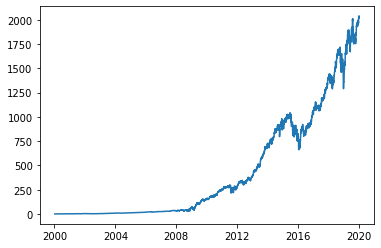

In [19]:
plt.plot(cumulative["date"],cumulative["pv"])

In [21]:
pd.DataFrame([parameter]).to_csv("parameter.csv")